## Pretrain single model

In [34]:
%load_ext autoreload
%autoreload 2


import sys; sys.path.append(2*'../')

import torch
import torch.nn as nn
from pathlib import Path
import wandb
from torchdyn.numerics import odeint
from tqdm.auto import tqdm

from math import pi as π

from kse527.systems.rendering.cartpole import CartPoleRendering
from kse527.control.cost import IntegralCost
from kse527.models.activations.snake import Snake
from kse527.tasks.default import DynamicSystemLearner
from notebooks.mpc.mpc import TorchMPC
from notebooks.mpc.utils_mpc import CartPole, CartpoleIntegralCost, BoxConstrainedController, RandConstController
from notebooks.mpc.utils import NeuralModelWrapper


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparameters

In [43]:
device = torch.device('cpu')

# Initial distribution of states and controller
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
u_min, u_max = -30, 30

# Build model via wrapper
# Here you can change activation functions, dimensions, activations, quantization etc
hdim = 32
inner_nn = nn.Sequential(nn.Linear(5, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
opt = torch.optim.Adam(inner_nn.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[5000, 10000, 15000], gamma=0.5)# dont use for few epochs. 20000 seem to be ok
model_nn = NeuralModelWrapper(inner_nn, RandConstController())


# Hyperparams
loss_func = nn.MSELoss()
epochs = 20000
bs = 128
dt = 0.02
span = torch.linspace(0, dt, 2)
losses = []

# Nominal system
sys_nominal = CartPole(u=RandConstController())

## Main training loop

Each epoch we sample from a distribution of controllers and states

This makes the learned model more robust since it basically learns any possible combination of states and controllers

--> Control is easier with this type of training

In [44]:
from tqdm.auto import trange
with trange(0, epochs, desc="Epochs") as stepx:
    for i in stepx:    
        x0 = init_dist.sample((bs,)).to(device)
        val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
        model_nn.u.u0 = val
        sys_nominal.u.u0 = val
        
        # Compute loss
        _, sol_gt = odeint(sys_nominal.dynamics, x0, span, solver='rk4')[-1] # nominal: real system
        sol_model = model_nn.step(0, x0) # our model 
        loss = loss_func(sol_gt, sol_model)

        # Optimization step
        loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
        stepx.set_postfix({'Loss':loss})
        # print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
        losses.append(loss.detach().cpu().item())

Epochs:   0%|          | 0/20000 [00:00<?, ?it/s]

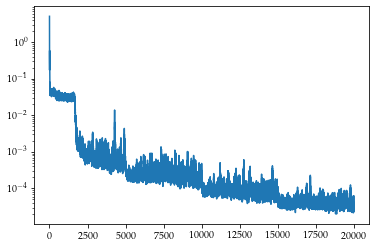

In [45]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale('log')

In [92]:
# Save model
from pathlib import Path
path = Path('saved_models/')

torch.save(model_nn.model, path / 'model_example.pt')